<a href="https://colab.research.google.com/github/savithrikb/dl-photo-restoration/blob/master/photo_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PHOTO RESTORATION USING RNN's**

In this notebook, we're going to define and train a CycleGAN to read in an image from a set 𝑋 and transform it so that it looks as if it belongs in set 𝑌 . Specifically, we'll look at a set of images that might be damaged, has lower resolution, and dull colors (older photos) as well as a set of high-quality, high-resolution images with bright colors (newer photos).

**LOAD AND VISUALIZE THE DATA**

Next, we have to load and visualize the training data. In order to do so we have to import certain libraries and modules.

In [8]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


KeyboardInterrupt: ignored

**Dataloader**

*We* have created function return dataloaders that can load data efficiently and in specified batches. This function is also responsible for making sure our images are of the right, square size (512x512x3) and converted into Tensor image types.

In [0]:
def get_data_loader(image_type, image_dir='gdrive/My Drive/photo_restoration/photos', 
                    image_size=512, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'old' or 'new'. 
       These images will be resized to 512x512x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(512),
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    

    return train_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X = get_data_loader(image_type='old')
dataloader_Y = get_data_loader(image_type='new')

**Display training images**

Defining a function to show the images as a grid that contains a batch of image data from set  𝑋 . The function will reshape some given images and converts them to NumPy images so that they can be displayed by plt.



In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

showing the images as a grid that contains a batch of image data from set y.

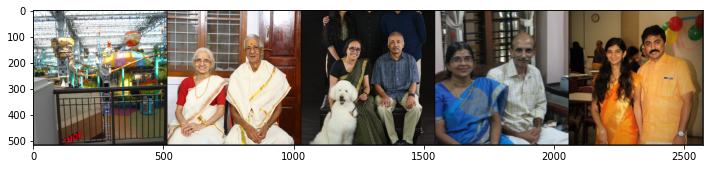

In [0]:

dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

**Pre-processing: scaling from -1 to 1**

We need to do a bit of pre-processing; we know that the output of our tanh activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [0]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [0]:

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


# Define the model
The CycleGan has a generator and a discrimator. The generator will  generate fake images to trick the discriminator, while the discriminator will try to distinguish the generated results from
real data.

## Discriminator
The discrminators attempt to classify the data as real or fake. Therefore real is indicated by an output close to 1 and fake as close to 0.

We used similiar architecture of the paper [Unsupervised Image Super-Resolution
using Cycle-in-Cycle Generative Adversarial Networks](http://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w13/Yuan_Unsupervised_Image_Super-Resolution_CVPR_2018_paper.pdf) for both discriminator and generator.

This network sees a 512x512x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function with negative slope 0.2 applied to their output, and the last acts as a classification layer that outputs one value.




In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Creating a discrimator class to define all convolutional layers and feedforward behavior.

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim = 64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)
        self.conv5 = conv(conv_dim * 8, 1, 4, stride = 1, batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        output = F.relu(self.conv1(x))
        output = F.relu(self.conv2(output))
        output = F.relu(self.conv3(output))
        output = F.relu(self.conv4(output))
        output = self.conv5(output)
        return output



#Generator

There are two generators. One will convert images from the X domain to the Y domain (G_XtoY). The other generator (G_YtoX) converts images from Y to X. These are made of an encoder, a conv net that is responsible for turning an image into a smaller feature representation, and a decoder, a transpose_conv net that is responsible for turning that representation into an transformed image.

The generator network has three parts, an encoder, a transformer, and a decoder. The input image is fed directly into the encoder, which shrinks the representation size while increasing the number of channels. The encoder is composed of three convolutional layers.
The transformer is a series of six residul blocks, also called ResNet blocks. Finally, the decoder is composed of three transpose convolutional layers (sometimes called de-conv layers) which upsample the output of the ResNet blocks and create a new image.




###Define ResidualBlock Class
To define the ResidualBlock class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. 

In [0]:

class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, 3, stride = 1)
        self.conv2 = conv(conv_dim, conv_dim, 3, stride = 1)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        return x + out
    

In order to define Generator we have to use the conv function, the ResidualBlock class, and the below deconv helper function. The deconv function will creates a a transpose convolutional layer + an optional batchnorm layer.

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

Next, we have to create the Generator architecture using the 3 layer encoder convolutional net, a series of residual blocks (the number of which is given by n_res_blocks), and then the decoder, a 3 layer transpose convolutional net.Since 𝐺𝑋𝑡𝑜𝑌  and  𝐺𝑌𝑡𝑜𝑋 have the same architecture, we only have to define one class for both and later instantiate two generators.

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        
        # 2. Define the resnet part of the generator
        resnet_layers = []
        for layer in range(n_res_blocks):
            resnet_layers.append(ResidualBlock(conv_dim * 4))
        
        self.resnet = nn.Sequential(*resnet_layers)

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim * 4, conv_dim * 2, 4)
        self.deconv2 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        
        out = self.resnet(out)
        
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))
        return out

### Create the complete network

Next, we have to generate a complete network using the classes that we defined above. First create two generators. One is to transform X to Y. The other is to transform Y to X. Then the discriminators. One is to checking the X and the other is to check Y.

In [0]:
import torch
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [20]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Only CPU available.


In [21]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

## Discriminator and Generator Losses

The loss function in GAN reflects the distance between the real images and the generated images. 

The discriminator tries to determine which images are real and which are fake (i.e., created by the generator). The loss is calculated as the mean squared error (MSE) between the output of the discriminator and the target value, zero (fake) or one (real).

The main idea of the generator is to make the generated images indistinguishable from the the orginal images. The loss is the MSE of the output of the discriminator and one (detected real image).

Finally, we have the cycle consistency loss. To ensure that the generated image corresponds to the original image, we take the generated image and put it through the opposite generator to see if we get the original image back. The cycle consistency loss gives the idea of how good a reconstructed image is, when compared to an original image. The cycle consistency loss can be calculated by taking the mean absolute error between the real images and the reconstructed images. This has a lambda_weight parameter that will weight the mean absolute error in a batch.

In [0]:
import torch
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1) ** 2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out ** 2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    return torch.mean(torch.abs(real_im - reconstructed_im)) * lambda_weight


In order to minimize the loss function we have to update the weights.According to the previous paper, we are using the Adam optimizers here.

In [0]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])